In [3]:
import numpy as np
import matplotlib.pyplot as plt

def generate_topology(N_ue, N_ap, N_t, width, length, min_dist=2.0, seed=None, plot=True):
    """
    Generate a random topology with users, APs, and targets in a rectangular area.
    """
    if seed is not None:
        np.random.seed(seed)

    def place_nodes(num_points, existing_points):
        # Ensure input is always an ndarray
        if isinstance(existing_points, list):
            existing_points = np.array(existing_points)
        if existing_points is None or existing_points.size == 0:
            existing_points = np.empty((0, 2))

        coords = []
        attempts = 0
        while len(coords) < num_points:
            x = np.random.uniform(0, width)
            y = np.random.uniform(0, length)
            new_point = np.array([x, y])

            # Combine all points so far
            all_points = np.vstack([existing_points, coords]) if len(coords) > 0 else existing_points

            # Check distances
            if all_points.shape[0] > 0:
                dists = np.linalg.norm(all_points - new_point, axis=1)
                if np.any(dists < min_dist):
                    attempts += 1
                    if attempts > 5000:
                        raise RuntimeError("Could not place nodes with given min_dist. Try reducing it.")
                    continue
            coords.append(new_point)

        return np.array(coords)

    # Place nodes sequentially
    users = place_nodes(N_ue, np.empty((0, 2)))
    aps = place_nodes(N_ap, users)
    targets = place_nodes(N_t, np.vstack([users, aps]))

    topology = {'users': users, 'aps': aps, 'targets': targets}

    # Plot topology
    if plot:
        plt.figure(figsize=(7, 6))
        plt.scatter(users[:,0], users[:,1], c='blue', marker='o', label='Users')
        plt.scatter(aps[:,0], aps[:,1], c='red', marker='^', label='APs')
        plt.scatter(targets[:,0], targets[:,1], c='green', marker='s', label='Targets')
        plt.xlim([0, width])
        plt.ylim([0, length])
        plt.xlabel("Width (m)")
        plt.ylabel("Length (m)")
        plt.title("Random ISAC Topology")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()

    return topology

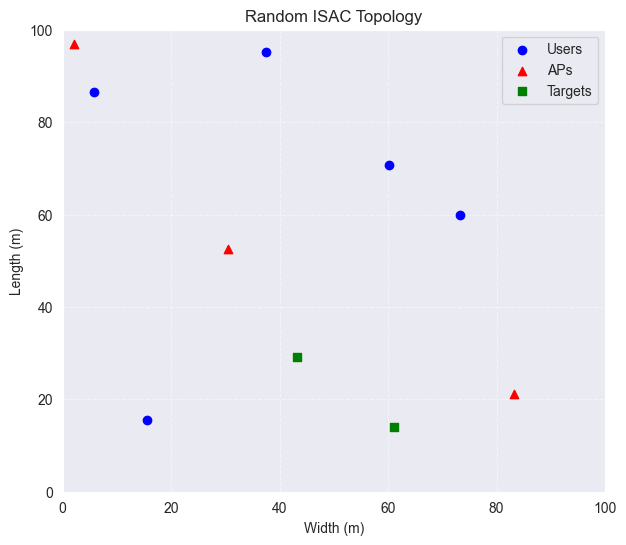

User coordinates:
 [[37.45401188 95.07143064]
 [73.19939418 59.86584842]
 [15.60186404 15.59945203]
 [ 5.80836122 86.61761458]
 [60.11150117 70.80725778]]
AP coordinates:
 [[ 2.05844943 96.99098522]
 [83.24426408 21.23391107]
 [30.4242243  52.47564316]]
Target coordinates:
 [[43.19450186 29.12291402]
 [61.18528947 13.94938607]]


In [4]:

topo = generate_topology(
    N_ue=5,
    N_ap=3,
    N_t=2,
    width=100,
    length=100,
    min_dist=5,
    seed=42
)
print("User coordinates:\n", topo['users'])
print("AP coordinates:\n", topo['aps'])
print("Target coordinates:\n", topo['targets'])

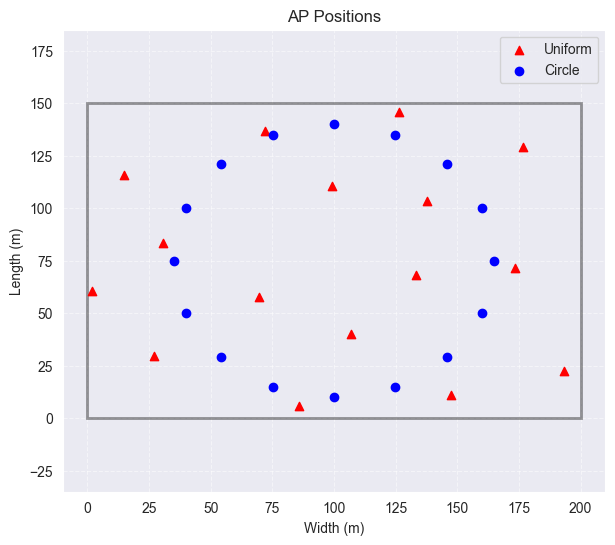

In [100]:
import warnings
import matplotlib.patches as patches

def generate_AP_positions(N_ap, env_x, env_y, mode='uniform', min_dist=None, circle_radius=None, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    if mode == 'uniform':
        if min_dist is None:
            x_coords = np.random.uniform(0, env_x, N_ap)
            y_coords = np.random.uniform(0, env_y, N_ap)
            ap_positions = np.column_stack([x_coords, y_coords])
        else:
            if min_dist > env_x or min_dist > env_y:
                raise ValueError("min_dist exceeds env_x and/or env_y dimensions.")
            x = np.random.uniform(0, env_x)
            y = np.random.uniform(0, env_y)
            ap_positions = np.column_stack([x, y])
            attemps = 0
            while len(ap_positions) < N_ap:
                x = np.random.uniform(0, env_x)
                y = np.random.uniform(0, env_y)
                new_point = np.column_stack([x, y])
                dists = np.linalg.norm(ap_positions - new_point, axis=1)
                if np.any(dists < min_dist):
                    attemps += 1
                    if attemps > 5000:
                        # raise RuntimeError("Could not place nodes with given min_dist. Try reducing it.")
                        warnings.warn("Could not satisfy min_dist among all nodes.")
                        ap_positions = np.vstack([ap_positions, new_point])
                        continue
                    continue
                ap_positions = np.vstack([ap_positions, new_point])
    elif mode == 'circle':
        if circle_radius is None:
            raise ValueError("circle_radius must be specified for 'circle' mode.")
        if circle_radius > env_x or circle_radius > env_y:
            warnings.warn("circle_radius exceeds env_x and/or env_y dimensions.")
        x_coords = circle_radius * np.cos(np.linspace(0, 2 * np.pi, N_ap, endpoint=False)) + env_x / 2
        y_coords = circle_radius * np.sin(np.linspace(0, 2 * np.pi, N_ap, endpoint=False)) + env_y / 2
        ap_positions = np.column_stack([x_coords, y_coords])
    elif mode == 'line':
        ap_positions = np.linspace(0, env_x, N_ap, endpoint=False) # placeholder!!!
    else:
        raise ValueError("Invalid mode. Choose 'uniform' or 'circle'.")
    return ap_positions

N_ap = 16
env_x = 200
env_y = 150

ap_positions_uniform = generate_AP_positions(N_ap, env_x, env_y, mode='uniform', min_dist=35, random_state=None)
ap_positions_circle = generate_AP_positions(N_ap, env_x, env_y, mode='circle', circle_radius=65, random_state=None)

# print(ap_positions_uniform)

fig, ax = plt.subplots(figsize=(7, 6))

# Draw environment rectangle
rect = patches.Rectangle((0, 0), env_x, env_y, linewidth=2, edgecolor='black', facecolor='none', alpha=0.4)
ax.add_patch(rect)
ax.scatter(ap_positions_uniform[:, 0], ap_positions_uniform[:, 1], c='red', marker='^', label='Uniform')
ax.scatter(ap_positions_circle[:, 0], ap_positions_circle[:, 1], c='blue', marker='o', label='Circle')
env_margin = np.max([env_x, env_y]) / 2 + 10
ax.set_xlim([env_x/2 - env_margin, env_x/2 + env_margin])
ax.set_ylim([env_y/2 - env_margin, env_y/2 + env_margin])
ax.set_xlabel("Width (m)")
ax.set_ylabel("Length (m)")
ax.set_title("AP Positions")
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)

In [272]:

def placement_with_min_dist(N, env_x, env_y, min_dist, current_positions=None, min_dist_to_current_positions=None, max_attempts=5000, failed_action='warning', random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    if current_positions is None:
        current_positions = np.empty((0, 2))
    if min_dist_to_current_positions is None:
        min_dist_to_current_positions = 0
    new_positions = np.empty((0, 2))
    if max(min_dist, min_dist_to_current_positions) > env_x or max(min_dist, min_dist_to_current_positions) > env_y:
        raise ValueError("min_dist and/or min_dist_to_current_positions exceeds env_x and/or env_y dimensions.")
    env_max_dim = max(env_x, env_y)
    attempts = 0
    while len(new_positions) < N:
        x = np.random.uniform(0, env_x)
        y = np.random.uniform(0, env_y)
        new_point = np.column_stack([x, y])
        if len(new_positions) == 0 and len(current_positions) == 0:
            dists = env_max_dim
            dists_to_current_positions = env_max_dim
        elif len(new_positions) == 0 and len(current_positions) > 0:
            dists = env_max_dim
            dists_to_current_positions = np.linalg.norm(current_positions - new_point, axis=1)
        elif len(new_positions) > 0 and len(current_positions) == 0:
            dists = np.linalg.norm(new_positions - new_point, axis=1)
            dists_to_current_positions = env_max_dim
        else:
            dists = np.linalg.norm(new_positions - new_point, axis=1)
            dists_to_current_positions = np.linalg.norm(current_positions - new_point, axis=1)
        if np.any(dists < min_dist) or np.any(dists_to_current_positions < min_dist_to_current_positions):
            attempts += 1
            if attempts > max_attempts:
                if failed_action == 'error':
                    raise RuntimeError("Could not place nodes with given min_dist and/or min_dist_to_current_positions. Try reducing them.")
                else:
                    warnings.warn("Could not satisfy min_dist and/or min_dist_to_current_positions among all nodes.")
                    new_positions = np.vstack([new_positions, new_point])
                    continue
            continue
        new_positions = np.vstack([new_positions, new_point])
    return new_positions


def generate_AP_positions(N_ap, env_x, env_y, mode='uniform', min_dist=None, circle_radius=None, line_point1=None, line_point2=None, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    if mode == 'uniform':
        if min_dist is None:
            x_coords = np.random.uniform(0, env_x, N_ap)
            y_coords = np.random.uniform(0, env_y, N_ap)
            ap_positions = np.column_stack([x_coords, y_coords])
        else:
            ap_positions = placement_with_min_dist(N=N_ap, env_x=env_x, env_y=env_y, min_dist=min_dist, current_positions=None, failed_action='warning', random_state=random_state)
    elif mode == 'circle':
        if circle_radius is None:
            raise ValueError("circle_radius must be specified for 'circle' mode.")
        if circle_radius > env_x or circle_radius > env_y:
            warnings.warn("circle_radius exceeds env_x and/or env_y dimensions.")
        x_coords = circle_radius * np.cos(np.linspace(0, 2 * np.pi, N_ap, endpoint=False)) + env_x / 2
        y_coords = circle_radius * np.sin(np.linspace(0, 2 * np.pi, N_ap, endpoint=False)) + env_y / 2
        ap_positions = np.column_stack([x_coords, y_coords])
    elif mode == 'line':
        if line_point1 is None or line_point2 is None:
            raise ValueError("line_point1 and line_point2 must be specified for 'line' mode.")
        if line_point1[0] == line_point2[0] and line_point1[1] == line_point2[1]:
            raise ValueError("line_point1 and line_point2 must be different points.")
        x_coords = np.linspace(line_point1[0], line_point2[0], N_ap)
        y_coords = np.linspace(line_point1[1], line_point2[1], N_ap)
        ap_positions = np.column_stack([x_coords, y_coords])
    else:
        raise ValueError("Invalid mode. Choose 'uniform', 'circle', or 'line'.")
    return ap_positions




def generate_user_positions(N_cu, env_x, env_y, mode='uniform', min_user_dist=None, min_userAP_dist=None, ap_positions=None, circle_radius=None, line_point1=None, line_point2=None, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    if mode == 'uniform':
        if min_user_dist is None and min_userAP_dist is None:
            x_coords = np.random.uniform(0, env_x, N_cu)
            y_coords = np.random.uniform(0, env_y, N_cu)
            user_positions = np.column_stack([x_coords, y_coords])
        elif min_user_dist is not None and min_userAP_dist is None:
            user_positions = placement_with_min_dist(N=N_cu, env_x=env_x, env_y=env_y, min_dist=min_user_dist, current_positions=None,
                                                     failed_action='warning', random_state=random_state)
        elif min_user_dist is None and min_userAP_dist is not None:
            if ap_positions is None:
                raise ValueError("ap_positions must be provided when min_userAP_dist is specified.")
            user_positions = placement_with_min_dist(N=N_cu, env_x=env_x, env_y=env_y, min_dist=0, current_positions=ap_positions,
                                                     min_dist_to_current_positions=min_userAP_dist, failed_action='warning', random_state=random_state)
        else:
            if ap_positions is None:
                raise ValueError("ap_positions must be provided when min_userAP_dist is specified.")
            user_positions = placement_with_min_dist(N=N_cu, env_x=env_x, env_y=env_y, min_dist=min_user_dist, current_positions=ap_positions,
                                                     min_dist_to_current_positions=min_userAP_dist, failed_action='warning', random_state=random_state)
    elif mode == 'circle':
        if circle_radius is None:
            raise ValueError("circle_radius must be specified for 'circle' mode.")
        if circle_radius > env_x or circle_radius > env_y:
            warnings.warn("circle_radius exceeds env_x and/or env_y dimensions.")
        x_coords = circle_radius * np.cos(np.linspace(0, 2 * np.pi, N_cu, endpoint=False)) + env_x / 2
        y_coords = circle_radius * np.sin(np.linspace(0, 2 * np.pi, N_cu, endpoint=False)) + env_y / 2
        user_positions = np.column_stack([x_coords, y_coords])
    elif mode == 'line':
        if line_point1 is None or line_point2 is None:
            raise ValueError("line_point1 and line_point2 must be specified for 'line' mode.")
        if line_point1[0] == line_point2[0] and line_point1[1] == line_point2[1]:
            raise ValueError("line_point1 and line_point2 must be different points.")
        x_coords = np.linspace(line_point1[0], line_point2[0], N_cu)
        y_coords = np.linspace(line_point1[1], line_point2[1], N_cu)
        user_positions = np.column_stack([x_coords, y_coords])
    else:
        raise ValueError("Invalid mode. Choose 'uniform', 'circle', or 'line'.")
    return user_positions



def generate_target_positions(N_t, env_x, env_y, mode='uniform', min_target_dist=None, min_targetAP_dist=None, ap_positions=None, circle_radius=None, line_point1=None, line_point2=None, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    if mode == 'uniform':
        if min_target_dist is None and min_targetAP_dist is None:
            x_coords = np.random.uniform(0, env_x, N_t)
            y_coords = np.random.uniform(0, env_y, N_t)
            target_positions = np.column_stack([x_coords, y_coords])
        elif min_target_dist is not None and min_targetAP_dist is None:
            target_positions = placement_with_min_dist(N=N_t, env_x=env_x, env_y=env_y, min_dist=min_target_dist, current_positions=None, random_state=random_state)
        elif min_target_dist is None and min_targetAP_dist is not None:
            if ap_positions is None:
                raise ValueError("ap_positions must be provided when min_targetAP_dist is specified.")
            target_positions = placement_with_min_dist(N=N_t, env_x=env_x, env_y=env_y, min_dist=0, current_positions=ap_positions,
                                                       min_dist_to_current_positions=min_targetAP_dist, random_state=random_state)
        else:
            if ap_positions is None:
                raise ValueError("ap_positions must be provided when min_targetAP_dist is specified.")
            target_positions = placement_with_min_dist(N=N_t, env_x=env_x, env_y=env_y, min_dist=min_target_dist, current_positions=ap_positions,
                                                       min_dist_to_current_positions=min_targetAP_dist, random_state=random_state)
    elif mode == 'circle':
        if circle_radius is None:
            raise ValueError("circle_radius must be specified for 'circle' mode.")
        if circle_radius > env_x or circle_radius > env_y:
            warnings.warn("circle_radius exceeds env_x and/or env_y dimensions.")
        x_coords = circle_radius * np.cos(np.linspace(0, 2 * np.pi, N_t, endpoint=False)) + env_x / 2
        y_coords = circle_radius * np.sin(np.linspace(0, 2 * np.pi, N_t, endpoint=False)) + env_y / 2
        target_positions = np.column_stack([x_coords, y_coords])
    elif mode == 'line':
        if line_point1 is None or line_point2 is None:
            raise ValueError("line_point1 and line_point2 must be specified for 'line' mode.")
        if line_point1[0] == line_point2[0] and line_point1[1] == line_point2[1]:
            raise ValueError("line_point1 and line_point2 must be different points.")
        x_coords = np.linspace(line_point1[0], line_point2[0], N_t)
        y_coords = np.linspace(line_point1[1], line_point2[1], N_t)
        target_positions = np.column_stack([x_coords, y_coords])
    else:
        raise ValueError("Invalid mode. Choose 'uniform', 'circle', or 'line'.")
    return target_positions

# since 'generate_user_positions' and 'generate_target_positions' are exactly the same, change both to 'generate_entity_positions' funciton.


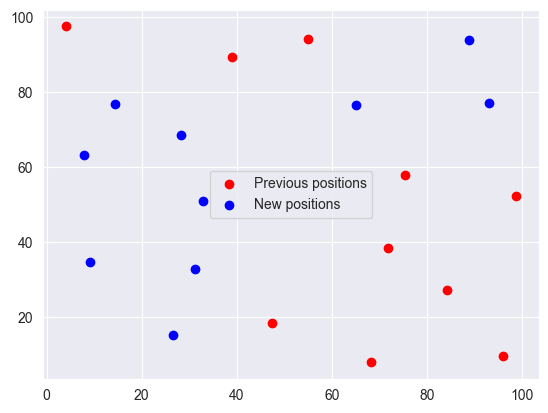

In [194]:
#### Test

prev_positions = placement_with_min_dist(N=10, env_x=100, env_y=100, min_dist=10, current_positions=None, failed_action='warning')

positions = placement_with_min_dist(N=10, env_x=100, env_y=100, min_dist=10, current_positions=prev_positions, min_dist_to_current_positions=20, failed_action='warning')

plt.scatter(prev_positions[:, 0], prev_positions[:, 1], c='red')
plt.scatter(positions[:, 0], positions[:, 1], c='blue')
plt.legend(['Previous positions', 'New positions'])

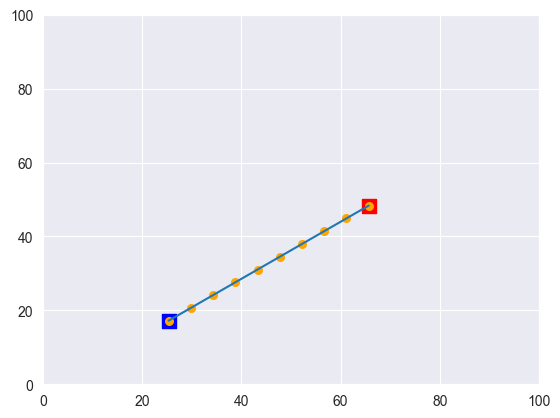

In [259]:
#### Test

x1 = np.random.uniform(0, 100, 1)
y1 = np.random.uniform(0, 100, 1)
first_point = np.column_stack([x1, y1])

x2 = np.random.uniform(0, 100, 1)
y2 = np.random.uniform(0, 100, 1)
second_point = np.column_stack([x2, y2])

m = (y2 - y1) / (x2 - x1)
b = y1 - m * x1

x = np.arange(np.min([x1, x2]), np.max([x1, x2]), 0.01)
y = m * x + b

n = 10
x_points = np.linspace(np.min([x1, x2]), np.max([x1, x2]), n)
y_points = m * x_points + b
positions = np.column_stack([x_points, y_points])

x_coords = np.linspace(x1, x2, n)
y_coords = np.linspace(y1, y2, n)
new_positions = np.column_stack([x_coords, y_coords])

plt.plot(x, y)
plt.scatter(first_point[:, 0], first_point[:, 1], c='red', marker='s', s=100)
plt.scatter(second_point[:, 0], second_point[:, 1], c='blue', marker='s', s=100)
# plt.scatter(positions[:, 0], positions[:, 1], c='green', marker='o', s=50)
plt.scatter(new_positions[:, 0], new_positions[:, 1], c='orange', marker='o', s=30)
plt.xlim([0, 100])
plt.ylim([0, 100])
plt.show()
# print(min(x1, x2), max(x1, x2))